# CAMOU: Learning Physical Vehicle Camouflages to Adversarially Attack Detectors in the Wild 

## Install requirements

### Install GraphViz and PyDot for Ploting Utils [Run when you don't have it]

In [1]:
!pip install pydot
!apt install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


### Enable Tensorflow 2.x for Colab

In [2]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Import Dependencies

In [3]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

import numpy as np
import math

## Learning A Clone Network Vθ(c,t)

![Clone Network](https://github.com/naufalso/camou-iclr2019-tf/blob/main/image-ref/CloneNetwork.png?raw=1)

### Define Module

In [4]:
class ConvMax(tf.keras.Model):
    def __init__(self, filters=4, kernel_size=3, pool_size=2, activation='relu'):
        super(ConvMax, self).__init__(name='ConvMax')

        self.conv = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', activation=activation)
        self.maxpool = tf.keras.layers.MaxPool2D((pool_size, pool_size))
    
    def call(self, input_tensor):
        x = self.conv(input_tensor)
        x = self.maxpool(x)
        return x

In [5]:
class RepeatedConvMax(tf.keras.Model):
    def __init__(self, repetitions=4, filters=4, kernel_size=3, pool_size=2, activation='relu', **kwargs):
        super(RepeatedConvMax, self).__init__(**kwargs)
        
        self.repetitions = repetitions
        self.filters = filters
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.activation = activation
        
        # Define a repeated ConvMax
        for i in range(self.repetitions):
            # Define a ConvMax layer, specifying filters, kernel_size, pool_size.
            setattr(self, f'convMax_{i}', ConvMax(self.filters, self.kernel_size, self.pool_size, self.activation))
    
    def call(self, input_tensor):
        # Connect the first layer
        x = getattr(self, 'convMax_0')(input_tensor)
       
        # Connect the existing layers
        for i in range(1, self.repetitions):
            x = getattr(self, f'convMax_{i}')(x)
        
        # return the last layer
        return x

### Define Object Detection Clone Network

In [6]:
class ODCloneNetwork(tf.keras.Model):
    def __init__(self, texture_size=64, **kwargs):
        super(ODCloneNetwork, self).__init__(**kwargs)
        
        self.input_texture = tf.keras.layers.Input(shape=(texture_size,texture_size,3,), name="texture_input")
        self.input_bg = tf.keras.layers.Input(shape=(64,64,3,), name="background_input")
        self.input_fg = tf.keras.layers.Input(shape=(64,64,3,), name="foreground_input")
        
        self.combined_input = [self.input_texture, self.input_bg, self.input_fg]
        
        # Define Texture Layers - Texture Repeated ConvMax = log2(texture_size)
        texture_repeated_conv_max = int(math.log(texture_size, 2)) - 2
        self.texture_layer = RepeatedConvMax(texture_repeated_conv_max, name='texture_layer')
        
        # Define Background Layers (image_size = 64 x 64, Repeated ConvMax = 4)
        self.background_layer = RepeatedConvMax(4, name='background_layer')
        
        # Define Foreground Layers (image_size = 64 x 64, Repeated ConvMax = 4)
        self.foreground_layer = RepeatedConvMax(4, name='foreground_layer')
        
        # Define last Conv2d
        self.last_conv2D_layer = tf.keras.layers.Conv2D(4, 3, activation='relu', name='last_conv2d_layer')
        
        # Define flatten
        self.flatten_layer = tf.keras.layers.Flatten()
        
        # Define last output sigmoid
        self.final_output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='final_output_layer')
        
        # Reinitialization to fix the model serialization
        self.final_output = self.call(self.combined_input)
        super(ODCloneNetwork, self).__init__(inputs=self.combined_input, outputs=self.final_output, **kwargs)
        
        
    def call(self, input_tensors):
        input_texture, input_background, input_foreground = input_tensors
        
        output_texture = self.texture_layer(input_texture)
        output_background = self.background_layer(input_background)
        output_foreground = self.foreground_layer(input_foreground)
        
        concat_layer = tf.keras.layers.concatenate([output_texture, output_background, output_foreground])
        
        x = self.last_conv2D_layer(concat_layer)
        x = self.flatten_layer(x)
        x = self.final_output_layer(x)
        
        return x

In [7]:
od_clone_network = ODCloneNetwork(64, name='ObjectDetectionCloneNetwork')
od_clone_network.summary()

Model: "ObjectDetectionCloneNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 texture_input (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 background_input (InputLayer)  [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 foreground_input (InputLayer)  [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 texture_layer (RepeatedConvMax  (None, 4, 4, 4)     556         ['texture_input[0][0]']          
 )                                                                      

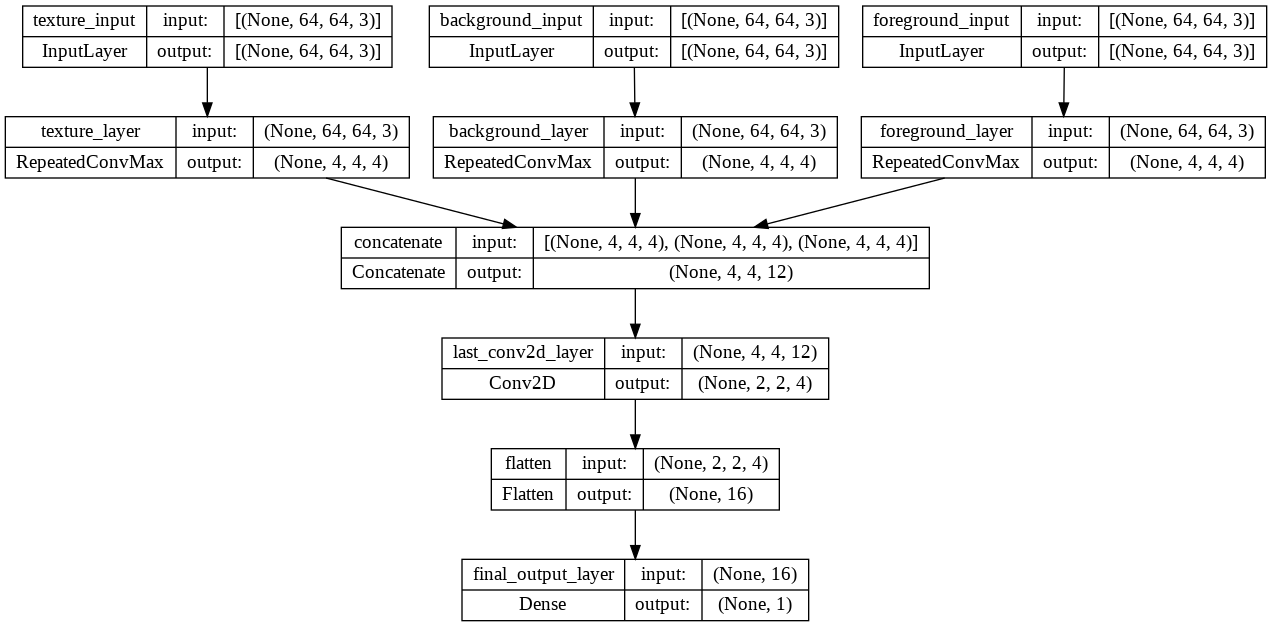

In [8]:
plot_model(od_clone_network, show_shapes=True, show_layer_names=True, expand_nested=True)

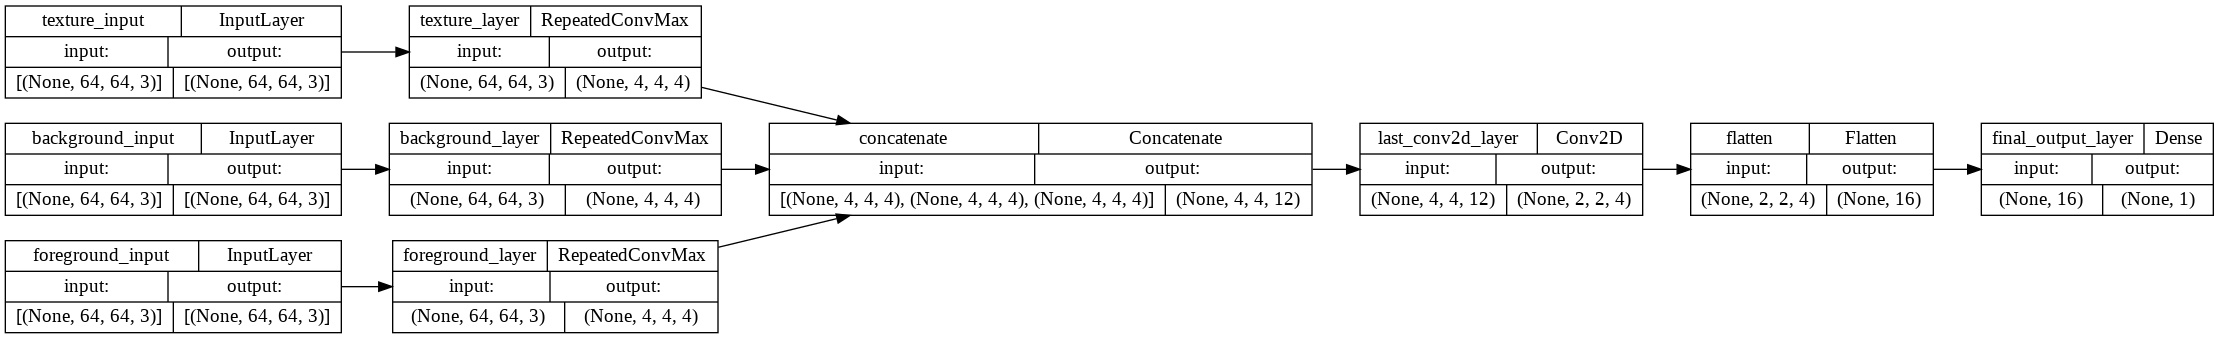

In [9]:
plot_model(od_clone_network, show_shapes=True, show_layer_names=True, expand_nested=True, rankdir='LR')